# Проект: классификация

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest

warnings.filterwarnings('ignore')
import optuna
from sklearn import ensemble, linear_model, metrics, preprocessing, tree
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import LabelEncoder

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Посмотрим на данные.

In [2]:
data = pd.read_csv(r'C:\Users\User\SkillFactory\data\bank_fin.zip', sep = ';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

**Целевая переменная *deposit***, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [3]:
# Исследуем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
print('Пропусков в признаке balance:', data['balance'].isnull().sum()) # Явные пропуски присутствуют только в признаке balance.

Пропусков в признаке balance: 25


В признаке job имеются пропущенные значения, но они обозначены специальным словом.

In [5]:
data['job'].value_counts() # Пропуски в признаке job обозначены как unknown. Их 70.

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Преобразуем признак balance, чтобы он считывался как вещественное число (float).

In [6]:
data['balance']#.value_counts() # Так выглядят данные.

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

In [7]:
data['balance'][data['balance'].isnull()==True] # Пропуски.

9       NaN
2859    NaN
2860    NaN
2888    NaN
2889    NaN
5356    NaN
5357    NaN
5358    NaN
5359    NaN
5360    NaN
5361    NaN
5362    NaN
5385    NaN
5386    NaN
5427    NaN
5428    NaN
5465    NaN
5467    NaN
5468    NaN
5480    NaN
5481    NaN
5570    NaN
5571    NaN
9954    NaN
9955    NaN
Name: balance, dtype: object

In [8]:
result = []

for balance in data['balance']:
    if type(balance)==str:
        balance = float(balance.replace(' ', '').replace('$', '').replace(',', '.'))
#         print(balance)
        result.append(balance)
    else:
        result.append(balance)
        
len(result) # Проверяем соответствие длины списка и длины датасета.

11162

In [9]:
data['balance'] = result
data['balance'] # Теперь данные выглядят так.

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

Обработаем пропуски в признаке balance, заменим их на медианные значения.

In [10]:
data['balance'] = data['balance'].fillna(data['balance'].median())
data['balance'].isnull().sum() # Проверям на пропуски.

0

Обработаем пропуски в категориальных признаках job и education, заменив их на модальные значения.

In [11]:
# Заменим модой (management) пропущенные значения в признаке job.
data['job'] = data['job'].replace('unknown', data['job'].mode()[0])
data['job'].value_counts() # Как видим количество значений management увеличилось на 70.

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [12]:
# Заменим модой (secondary) пропущенные значения в признаке education.
data['education'] = data['education'].replace('unknown', data['education'].mode()[0])
data['education'].value_counts() # Проверяем. Значений secondary увеличилось на 497.

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

Удалим выбросы в признаке balance.

In [13]:
# удалите все выбросы для признака balance
Q1 = data['balance'].quantile(0.25)
Q3 = data['balance'].quantile(0.75)
IQR = Q3 - Q1 # Межквартильный размах.
# Нижняя граница выбросов.
a = Q1 - 1.5*IQR
# Верхняя граница выбросов.
b = Q3 + 1.5*IQR
data_1 = data[(data['balance'] <= b) & (data['balance'] >= a)] # Создали новый датафрейм без выбросов по признаку balance.

## Часть 2:  Разведывательный анализ

Изучим соотношение классов в данных на предмет несбалансированности.

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

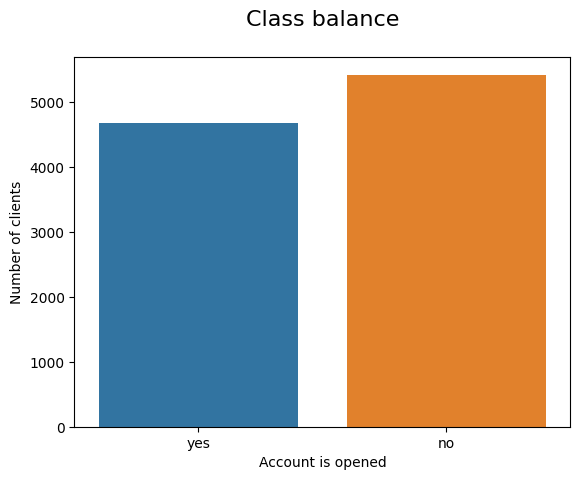

In [14]:
# data_1['deposit'] = data_1['deposit'].replace('yes', 1)
# data_1['deposit'] = data_1['deposit'].replace('no', 0)

display(data_1['deposit'].value_counts())
display(data_1['deposit'].value_counts(normalize=True))

ax = sns.countplot(x=data_1['deposit'])
ax.set(xlabel='Account is opened', ylabel='Number of clients')
ax.set_title('Class balance\n', fontsize=16);

Рассчитаем описательные статистики для количественных переменных.

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


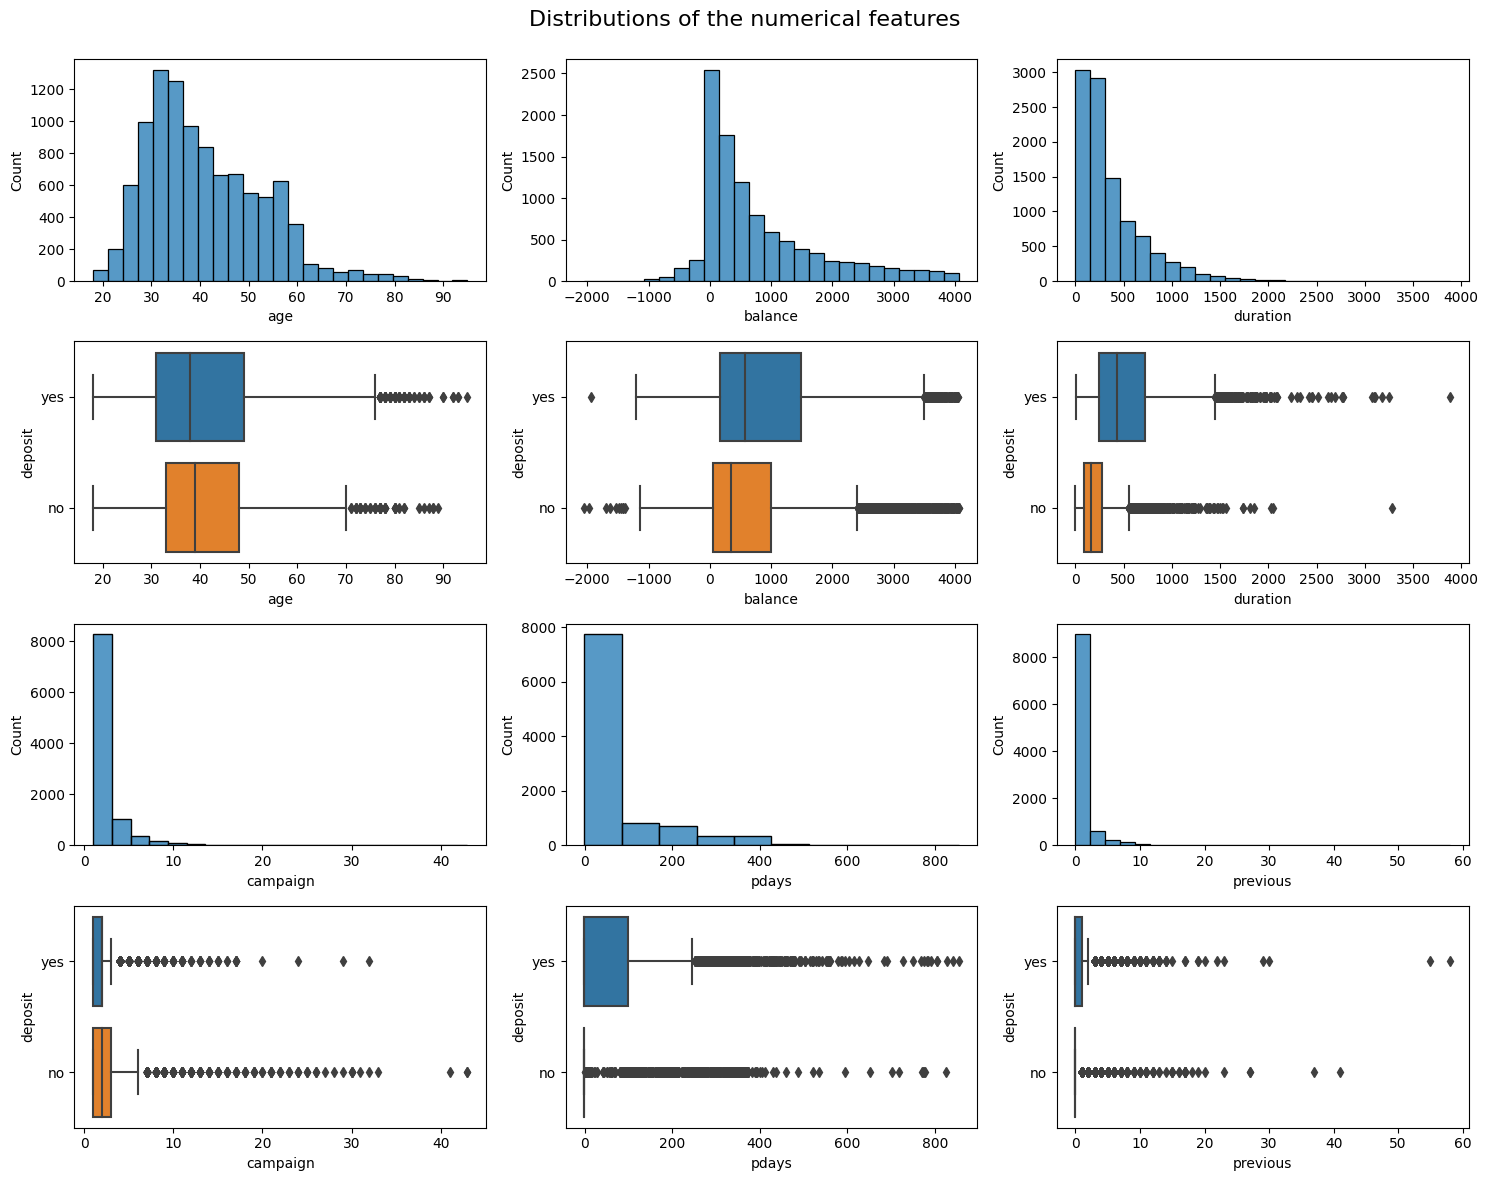

In [15]:
display(data_1.describe())

fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(data_1['age'], bins=25, ax=ax[0,0])       # Возраст
sns.histplot(data_1['balance'], bins=25, ax=ax[0,1])   # Баланс
sns.histplot(data_1['duration'], bins=25, ax=ax[0,2])  # Продолжительность контакта
sns.boxplot(data=data_1, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=data_1, x='balance', y='deposit', ax=ax[1,1])
sns.boxplot(data=data_1, x='duration', y='deposit', ax=ax[1,2])
sns.histplot(data_1['campaign'], bins=20, ax=ax[2,0])  # Количество контактов
sns.histplot(data_1['pdays'], bins=10, ax=ax[2,1])     # Количество дней после предыдущей кампании
sns.histplot(data_1['previous'], bins=25, ax=ax[2,2])  # Количество предыдущих контактов
sns.boxplot(data=data_1, x='campaign', y='deposit', ax=ax[3,0])
sns.boxplot(data=data_1, x='pdays', y='deposit', ax=ax[3,1])
sns.boxplot(data=data_1, x='previous', y='deposit', ax=ax[3,2])
plt.suptitle('Distributions of the numerical features\n', fontsize=16)
plt.tight_layout()

#### *Общий вид распределений, выбросы*

* Возраст (age). Пик распределения возраста приходится на 30-35 лет с достаточно большим количеством клиентов допенсионного возраста, количество клиентов старше 60 лет резко падает. Распределение с правой асимметрией в сторону старшего возраста.
* Баланс (balance). Есть небольшое количество отрацительных балансов. В остальном распределение логнормальное с преобладанием небольших балансов. Возможно, следует дополнительно убрать выбросы отрицательного баланса, расположенные левее границы распределения (менее -1100).
* Продолжительность контакта (duration). Средняя продолжительность контакта около 5 мин. Распределение логнормальное. Возможно наличие выбросов - контакт более 30 мин.
* Количество контактов (campaign). Логнормальное. Выбросы - число контактов более 15.
* Количество дней с момента предыдущей кампании (pdays). Логнормальное. Выбросы - более 500 дней.
* Количество предыдущих контактов (previous). Логнормальное. Выбросы аналогичны признаку campaign - более 15.

Для более точного определения границ распределений и удаления выбросов желательно предварительно преобразовать часть признаков в логарифмическую шкалу и применить критерий Тьюки или 3 * sigma.

#### *Влияние на целевой признак*

Визуально значимые отличия в распределениях по отношению к целевому признаку - открытию депозита (deposit) - наблюдаются у нескольких признаков (см. диаграммы размаха). На вероятное открытие депозита указывает продолжительность контакта - чем он дольше, тем выше шансы положительного результата. Наоборот, большее количество контактов говорит о меньших шансах, т.е. попытки контактировать с клиентом более нескольких раз не имеют особого смысла, результат либо достигается при первых контактах, либо не достигается вообще. Более вероятно открытие депозита у клиентов с большей суммой на счете. Распределение признаков pdays и previous говорит о том, что старый друг лучше новых двух - большинство клиентов, не открывших депозит, относятся к новым (pdays=-1, previous=0). Распределение по возрасту для клиентов, не открывших депозит, имеет меньшую дисперсию по сравнению с открывшими, но медианные значения почти не отличаются.

Рассчитаем описательные статистики для категориальных переменных.

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


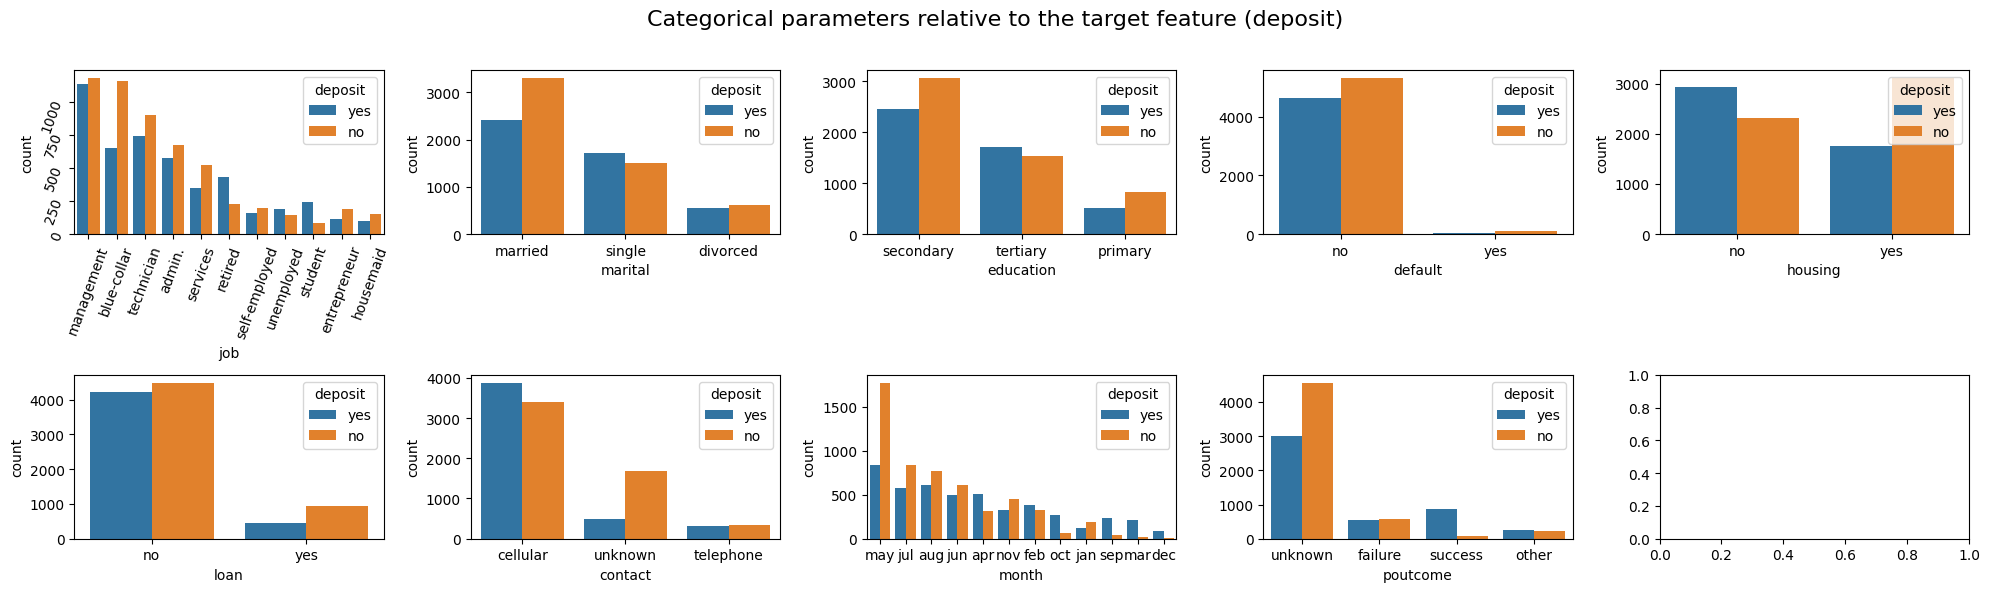

In [16]:
display(data_1.describe(include='object'))

fig, ax = plt.subplots(2, 5, figsize=(20, 6))

# Сфера занятости
sns.countplot(
    data=data_1, x='job', hue='deposit', 
    order=data_1['job'].value_counts().index, ax=ax[0,0])

# Семейное положение
sns.countplot(
    data=data_1, x='marital', hue='deposit',
    order=data_1['marital'].value_counts().index, ax=ax[0,1])

# Уровень образования
sns.countplot(
    data=data_1, x='education', hue='deposit',
    order=data_1['education'].value_counts().index, ax=ax[0,2])

# Наличие просроченного кредита
sns.countplot(
    data=data_1, x='default', hue='deposit',
    order=data_1['default'].value_counts().index, ax=ax[0,3])

# Наличие ипотеки
sns.countplot(
    data=data_1, x='housing', hue='deposit',
    order=data_1['housing'].value_counts().index, ax=ax[0,4])

# Наличие потребительского кредита
sns.countplot(
    data=data_1, x='loan', hue='deposit',
    order=data_1['loan'].value_counts().index, ax=ax[1,0])

# Тип контакта с клиентом
sns.countplot(
    data=data_1, x='contact', hue='deposit', 
    order=data_1['contact'].value_counts().index, ax=ax[1,1])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=data_1, x='month', hue='deposit',
    order=data_1['month'].value_counts().index, ax=ax[1,2])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=data_1, x='poutcome', hue='deposit',
    order=data_1['poutcome'].value_counts().index, ax=ax[1,3])
ax[0,0].tick_params(labelrotation=70)
plt.suptitle(
    'Categorical parameters relative to the target feature (deposit)\n',
    fontsize=16)
plt.tight_layout()

На рисунке видим соотношения различных категорий клиентов в разрезе достижения целевого признака - открытия депозита (deposit). Можно сказать, что наиболее склонны к открытию депозита следующие категории клиентов:

* пенсионеры и студенты (при небольшом относительном количестве и тех и других);
* клиенты, по которым был достигнут успех в предыдущей маркетинговой кампании - подавляющее большинство дают положительный результат и в текущей кампании;
* неженатые/незамужние клиенты, а также клиенты, не имеющие ипотеки (и те, и другие - в меньшей степени, однако в этих категориях число клиентов, открывших депозит, превышает число отрицательных результатов, что довольно нетипично для выборки в целом);
* клиенты, с которыми связывались по мобильному телефону - та же картина.

Наиболее неудачные результаты по привлечению к открытию депозита:

* "синие воротнички";
* клиенты с потребительскими кредитами

По какой-то причине наблюдаются значительные различия в успешности маркетинговой кампании по месяцам: исключительно успешные результаты в марте, апреле, сентябре, октябре и декабре, но существенный провал в мае. Данное обстоятельство требует дополнительного изучения в контексте построения модели машинного обучения - результаты могут быть связаны с конкретными "локальными" обстоятельствами маркетинговой кампании и не отражать общей тенденции (зависимости от времени года). Включение такой локальной зависимости в модель приведет к успешному предсказанию текущей ситуации, в том числе на тестовой выборке, однако нет гарантии, что новые данные будут соответствовать модели.

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [17]:
data_1.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


Как видно из вывода клиенты со статусом предыдущей кампании success открывают депозит значительно чаще.

Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит.

In [18]:
# процент отказов/согласия по месяцам:
(data_1.groupby('month')['deposit'].value_counts(normalize=True).unstack() \
    * 100).sort_values('no', ascending=False)  

deposit,no,yes
month,,
may,67.863966,32.136034
jan,60.815047,39.184953
jul,58.956276,41.043724
nov,58.461538,41.538462
aug,55.956679,44.043321
jun,54.891304,45.108696
feb,45.557123,54.442877
apr,38.192771,61.807229
oct,18.507463,81.492537


Максимум отказов в процентном соотношении - май.

Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от него.

In [19]:
conditions = [
    (data_1['age'] < 30),
    (data_1['age'] >= 30) & (data_1['age'] < 40),
    (data_1['age'] >= 40) & (data_1['age'] < 50),
    (data_1['age'] >= 50) & (data_1['age'] < 60),
    (data_1['age'] >= 60)]
choices = [1, 2, 3, 4, 5]
data_1['age_group'] = np.select(conditions, choices)
# data_1[['age', 'age_group']].head()

data_1.groupby('age_group')['deposit'].value_counts()

age_group  deposit
1          yes         861
           no          594
2          no         2245
           yes        1716
3          no         1444
           yes         938
4          no          984
           yes         670
5          yes         496
           no          157
Name: deposit, dtype: int64

In [20]:
piv_tab = (data_1.groupby('age_group')['deposit'].value_counts(normalize=True) \
    * 100).unstack().reset_index() # процент отказов/согласия по группам
piv_tab

deposit,age_group,no,yes
0,1,40.824742,59.175258
1,2,56.677607,43.322393
2,3,60.621327,39.378673
3,4,59.492140,40.507860
4,5,24.042879,75.957121


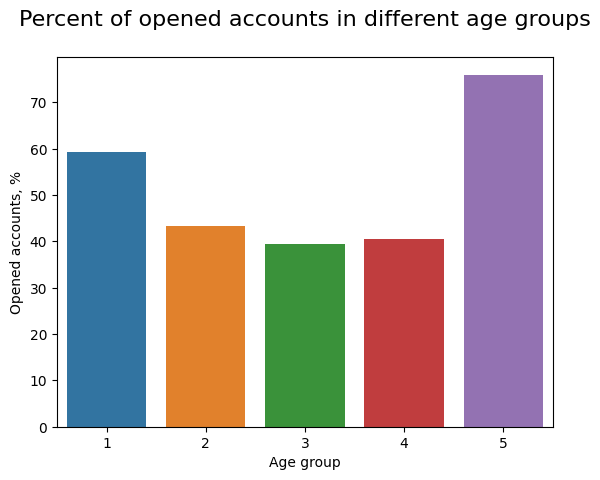

In [21]:
ax = sns.barplot(
    data=piv_tab,  y='yes', x='age_group'#,
#     order=['youth', 'thirties', 'forties', 'fifties', 'elders'] # Если именовать возрасные группы.
)
ax.set(ylabel='Opened accounts, %', xlabel='Age group')
ax.set_title('Percent of opened accounts in different age groups\n', 
             fontsize=16);

In [22]:
sns.__version__ # 0.11.2

'0.11.2'

Более склонны окрывать депозит, чем отказываться от него 1-я и 5-я возрастные группы.

Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса.

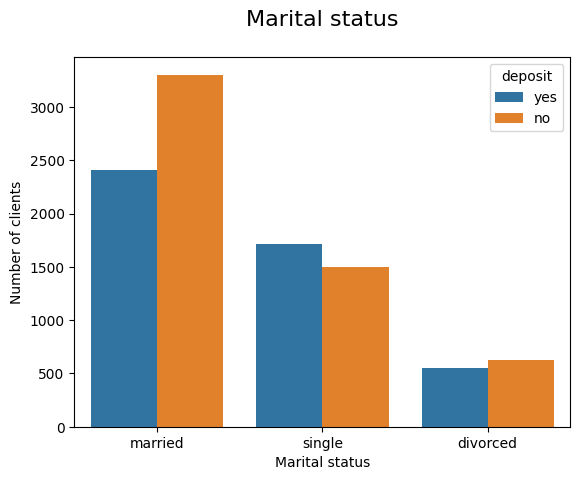

In [23]:
ax = sns.countplot(data=data_1, x='marital', hue='deposit')
ax.set(xlabel='Marital status', ylabel='Number of clients')
ax.set_title('Marital status\n', fontsize=16);

Наиболее многочисленная группа - семейные, наиболее малочисленная - разведенные. Неженатые/незамужние более склонны к открытию депозита, чем семейные.

Построим визуализацию для открывших и неоткрывших депозит в зависимости от образования.

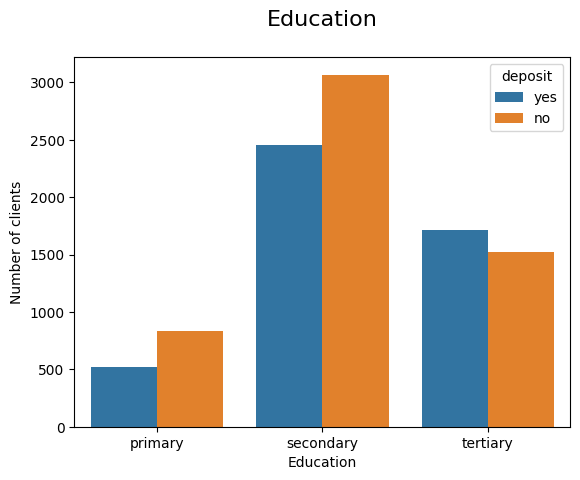

In [24]:
ax = sns.countplot(data=data_1, x='education', hue='deposit',
              order=['primary', 'secondary', 'tertiary'])
ax.set(xlabel='Education', ylabel='Number of clients')
ax.set_title('Education\n', fontsize=16);

У большинства клиентов среднее образование. Более склонны к открытию депозита клиенты с высшим образованием.

Построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости.

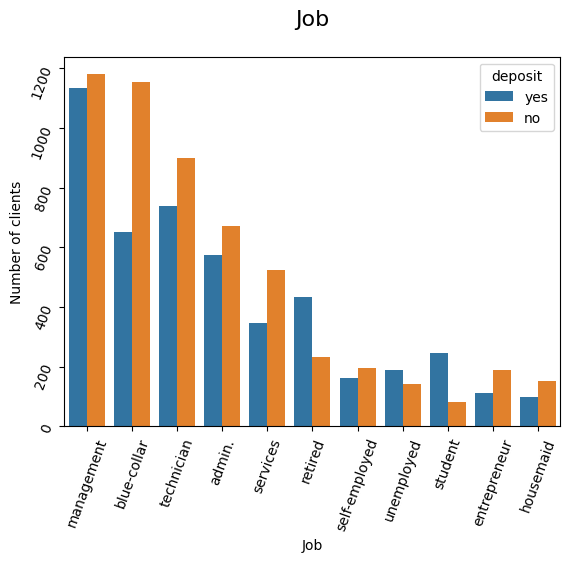

In [25]:
ax= sns.countplot(data=data_1, x='job', hue='deposit', 
              order=data_1['job'].value_counts().index)
ax.tick_params(labelrotation=70)
ax.set(xlabel='Job', ylabel='Number of clients')
ax.set_title('Job\n', fontsize=16);

Выделяется малый процент открытия депозитов у "синих воротничков" и большой - у пенсионеров и студентов. Важно отметить, что при этом "синие воротнички" составляют вторую по численности категорию клиентов (стоить подумать о способах привлечения этой категории).

Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны (если рассматривать тех, кто открыл депозит)

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


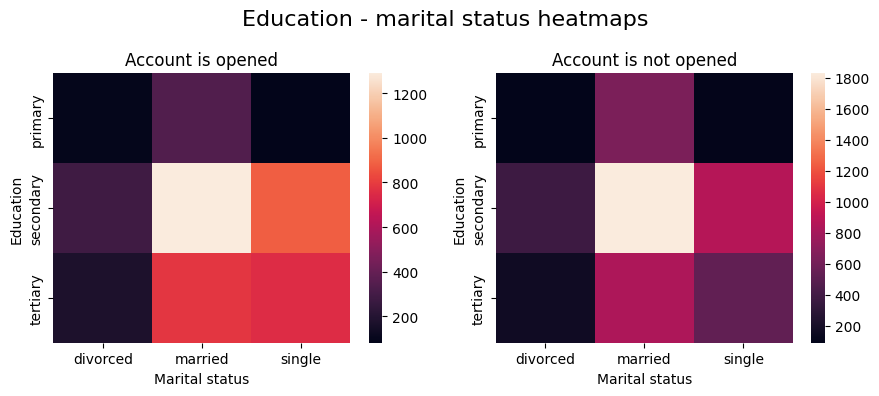

In [26]:
success = data_1[data_1['deposit']=='yes']
fail = data_1[data_1['deposit']=='no']
success_pivot = success.groupby(
    ['education', 'marital'])['marital'].count().unstack()
## or:
#success_pivot = pd.pivot_table(success,     
#    index='education', columns='marital', values='age', aggfunc='count')  
fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

display(success_pivot, fail_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, ax=ax[0])
sns.heatmap(fail_pivot, ax=ax[1])
ax[0].set_title('Account is opened')
ax[1].set_title('Account is not opened')
ax[0].set(xlabel='Marital status', ylabel='Education')
ax[1].set(xlabel='Marital status', ylabel='Education')
plt.suptitle('Education - marital status heatmaps', fontsize=16)
plt.tight_layout()

В обеих категориях (открывшие и неоткрывшие депозит) преобладают семейные клиенты со средним образованием.

## Часть 3: преобразование данных

Закодируем признак education.

In [27]:
# Порядковое кодирование
# 0 - primary, 1 - secondary, 2 - tertiary
label_enc = preprocessing.LabelEncoder()
data_1['education'] = label_enc.fit_transform(data_1['education'])

Преобразуем бинарные переменные в представление из нулей и единиц.

In [28]:
data_1['default_BIN'] = data_1['default'].apply(lambda x: 1 if x=='yes' else 0)
data_1['housing_BIN'] = data_1['housing'].apply(lambda x: 1 if x=='yes' else 0)
data_1['loan_BIN'] = data_1['loan'].apply(lambda x: 1 if x=='yes' else 0)
data_1['deposit'] = data_1['deposit'].apply(lambda x: 1 if x=='yes' else 0) # Преобразуем целевую переменную тоже (на будущее).

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

* 'job';
* 'marital';
* 'contact';
* 'month';
* 'poutcome'.

Создадим для них dummy-переменные и добавим их в набор данных.

In [29]:
dummies = pd.get_dummies(data_1[[
    'job', 'marital', 'contact', 'month', 'poutcome']])
data = pd.concat([data_1, dummies], axis=1)

In [30]:
data.shape

(10105, 54)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  object 
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  object 
 7   loan               10105 non-null  object 
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

Удаляем преобразованные признаки типа object.

In [32]:
obj_cols = data.select_dtypes('object').columns
data.drop(columns=obj_cols, inplace=True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   balance            10105 non-null  float64
 3   day                10105 non-null  int64  
 4   duration           10105 non-null  int64  
 5   campaign           10105 non-null  int64  
 6   pdays              10105 non-null  int64  
 7   previous           10105 non-null  int64  
 8   deposit            10105 non-null  int64  
 9   age_group          10105 non-null  int32  
 10  default_BIN        10105 non-null  int64  
 11  housing_BIN        10105 non-null  int64  
 12  loan_BIN           10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности.

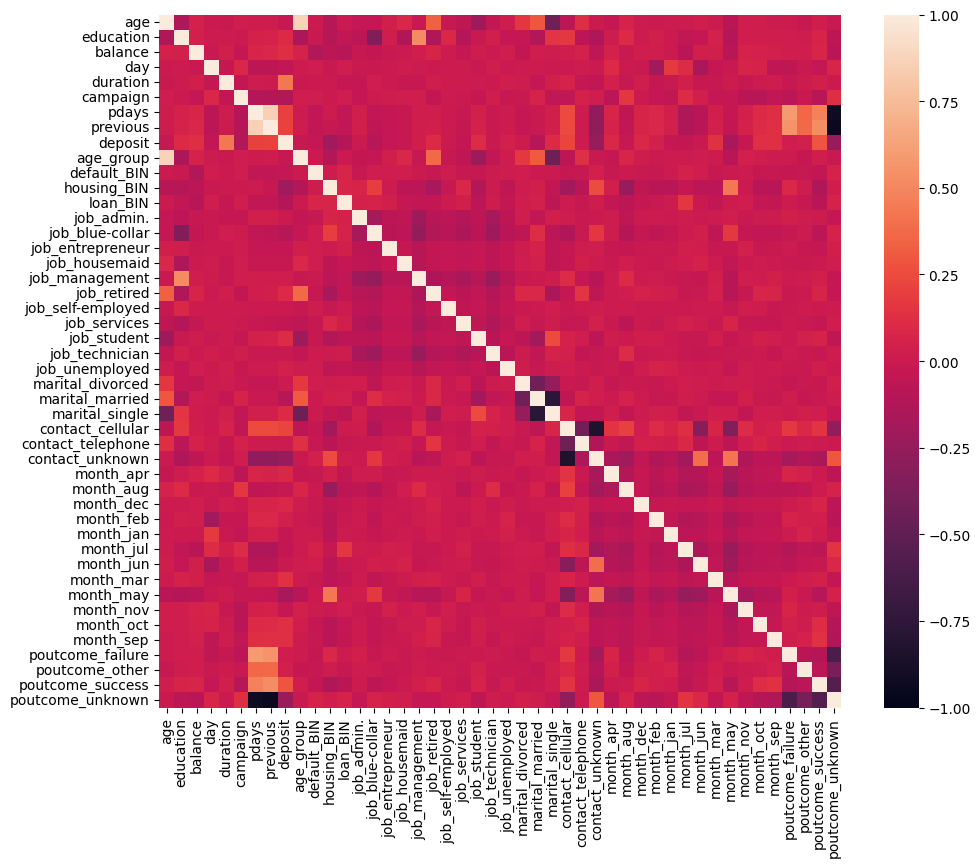

In [34]:
# Корреляционная матрица 
# Используем корреляцию Кендала - распределение признака может быть 
# не нормальным, связь признаков не обязательно является монотонной функцией
corr_matrix = data.corr(method='kendall')

# Тепловая карта
fig = plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix,  vmin=-1, vmax=1);

Вычисляем мультиколлинеарные признаки, порог 0.9 (порог в соответствии с требованиями задания).
Использую заготовленную функцию определения мультиколлинеарных признаков.

In [35]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()

get_correlated(corr_matrix, thres=0.9)

previous -- poutcome_unknown   -0.938271
pdays -- poutcome_unknown      -0.925560
dtype: float64

Большой коэффициент корреляции между previous, poutcome_unknown и pdays обусловлен сильной несбалансированностью каждого из признаков - большинство экземпляров показывают одно и то же значение признака:

In [36]:
display(data['poutcome_unknown'].value_counts())
display(data['previous'].value_counts()[:3])
display(data['pdays'].value_counts()[:3])

1    7570
0    2535
Name: poutcome_unknown, dtype: int64

0    7568
1     796
2     612
Name: previous, dtype: int64

-1      7568
 92       88
 182      77
Name: pdays, dtype: int64

Корреляция с целевым признаком.

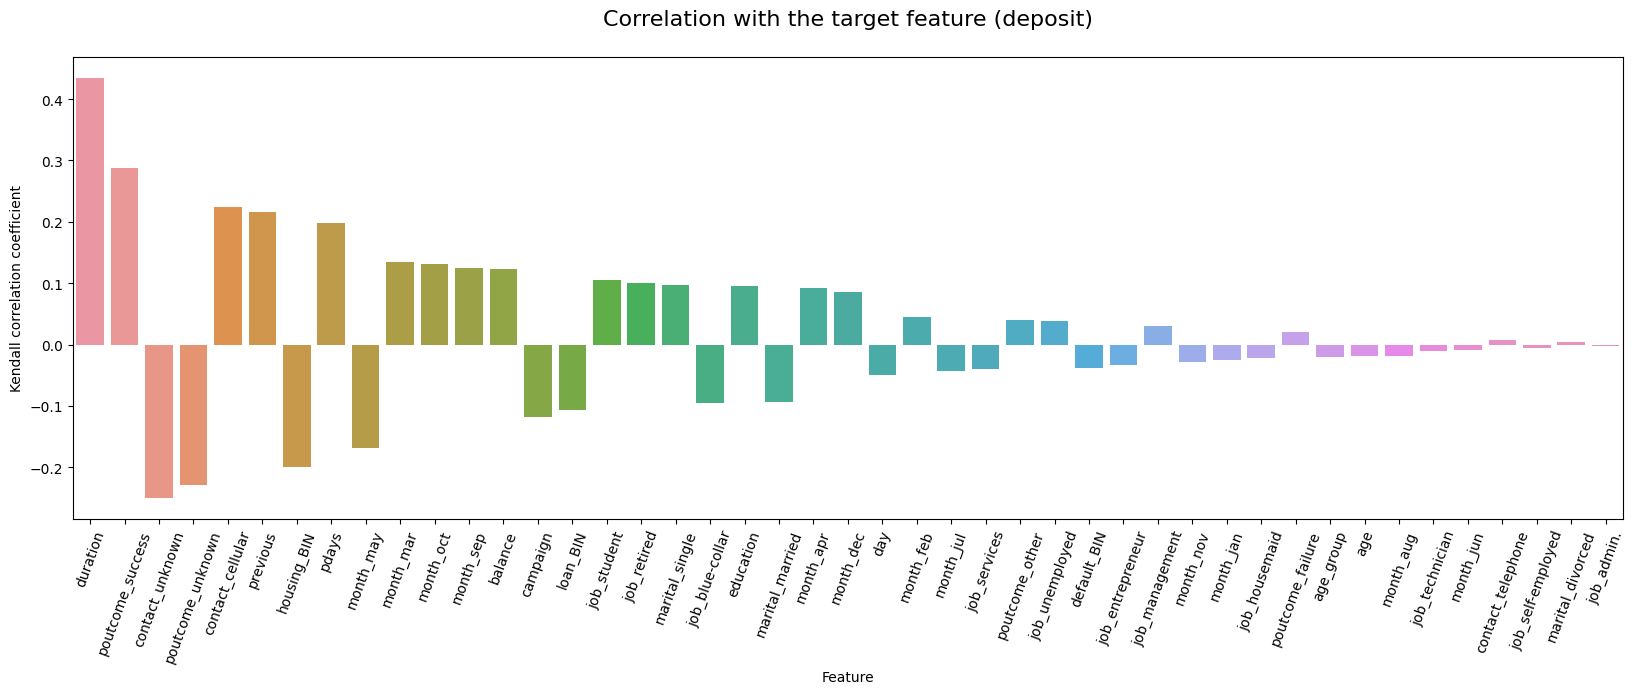

In [37]:
fig = plt.figure(figsize=(20,6))
plot_data = corr_matrix.drop('deposit')  # Убираем корреляцию "сам с собой"
feature_order = abs(plot_data['deposit']).sort_values(ascending=False).index
ax = sns.barplot(
    data=plot_data.reset_index(), x='index', y='deposit',
    order = feature_order)
plt.xticks(rotation=70)
ax.set(xlabel='Feature', ylabel='Kendall correlation coefficient')
ax.set_title('Correlation with the target feature (deposit)\n', fontsize=16);

Теперь определяем целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.

При разбиении зададим параметр random_state = 42, а размер тестовой выборки возьмём за 0.33. Добавим аргумент, определяющий сохранение соотношений целевого признака.

In [38]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [39]:
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (6770, 45)
Test shape: (3335, 45)


С помощью SelectKBest отберём 15 наиболее подходящих признаков. Отбор реализуем по обучающей выборке, используя параметр score_func = f_classif.

In [40]:
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print(f'Selected features:\n {selected_cols}')
X_train = selector.transform(X_train)
X_test =selector.transform(X_test)

Selected features:
 ['balance' 'duration' 'campaign' 'pdays' 'previous' 'housing_BIN'
 'loan_BIN' 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may'
 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


Нормализуем данные с помощью minmaxsxaler.

In [41]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оценим качество модели на тестовой выборке.

In [42]:
logregr = linear_model.LogisticRegression(
    random_state=42, 
    solver='sag', 
    max_iter=1000
)
logregr.fit(X_train, y_train)
y_train_pred = logregr.predict(X_train)
y_test_pred = logregr.predict(X_test)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.807     0.876     0.840      3634
           1      0.840     0.758     0.797      3136

    accuracy                          0.821      6770
   macro avg      0.824     0.817     0.818      6770
weighted avg      0.822     0.821     0.820      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.790     0.866     0.826      1790
           1      0.825     0.733     0.776      1545

    accuracy                          0.804      3335
   macro avg      0.807     0.799     0.801      3335
weighted avg      0.806     0.804     0.803      3335



Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

* criterion = 'entropy';
* random_state = 42.

Остальные параметры оставьте по умолчанию.

In [43]:
dtree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtree.fit(X_train, y_train)
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.999     1.000     1.000      3634
           1      1.000     0.999     1.000      3136

    accuracy                          1.000      6770
   macro avg      1.000     1.000     1.000      6770
weighted avg      1.000     1.000     1.000      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.773     0.764     0.768      1790
           1      0.730     0.740     0.735      1545

    accuracy                          0.753      3335
   macro avg      0.751     0.752     0.752      3335
weighted avg      0.753     0.753     0.753      3335



Задание: "Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой)."

В соответствии с условиями задания подбор параметра идет на тестовой выборке. В реальности ручной подбор гиперпараметра следует делать кросс-валидацией (например с помощью validation_curve() из sklearn) или на отдельной валидационной выборке.

Максимальная точность на тесте: 0.804
Оптимальная глубина дерева: 6


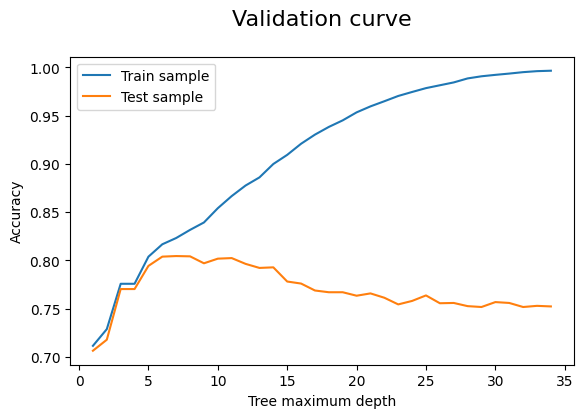

In [44]:
# Перебираем значения max_deph 
# Считаем accuracy на тренировочной и тестовой выборках
train_scores = []
test_scores = []
for max_depth in range(1,35):
    dtree = tree.DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42, 
        max_depth=max_depth
    )
    dtree.fit(X_train, y_train)
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    test_scores.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Рисунок
max_depth = list(range(1,35))
fig = plt.figure(figsize=(6.5, 4))
ax = sns.lineplot(x=max_depth, y=train_scores, label='Train sample')
sns.lineplot(x=max_depth, y=test_scores, label='Test sample')
ax.set(xlabel='Tree maximum depth', ylabel='Accuracy')
ax.set_title('Validation curve\n', fontsize=16);

# Оптимальный параметр
print(f'Максимальная точность на тесте: {np.amax(test_scores):.3f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

Подберём оптимальные параметры с помощью gridsearch.

In [45]:
# Сетка параметров - по условию задания
estimator = tree.DecisionTreeClassifier(
    criterion='entropy', random_state=42)

param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3,5,7]}

gsearch = GridSearchCV(
    estimator=estimator, 
    param_grid=param_grid, 
    scoring='f1'
)

gsearch.fit(X_train, y_train)

y_train_pred = gsearch.predict(X_train)
y_test_pred = gsearch.predict(X_test)

print(f'Наилучшие значения гиперпараметров: {gsearch.best_params_}')
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}
Обучающая выборка:
              precision    recall  f1-score   support

           0      0.820     0.857     0.838      3634
           1      0.825     0.782     0.803      3136

    accuracy                          0.822      6770
   macro avg      0.823     0.820     0.821      6770
weighted avg      0.822     0.822     0.822      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.803     0.840     0.821      1790
           1      0.804     0.761     0.782      1545

    accuracy                          0.803      3335
   macro avg      0.803     0.800     0.801      3335
weighted avg      0.803     0.803     0.803      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Обучим случайный лес со следующими параметрами:

* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

In [46]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    min_samples_leaf=5, 
    max_depth=10, 
    random_state=42
)
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.851     0.826     0.839      1790
           1      0.805     0.833     0.819      1545

    accuracy                          0.829      3335
   macro avg      0.828     0.830     0.829      3335
weighted avg      0.830     0.829     0.830      3335



Используем для классификации градиентный бустинг и сравним качество со случайным лесом.

In [47]:
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    min_samples_leaf=5,
    max_depth=5, 
    random_state=42
)
gboost.fit(X_train, y_train)

y_test_pred = gboost.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.850     0.816     0.833      1790
           1      0.796     0.833     0.814      1545

    accuracy                          0.824      3335
   macro avg      0.823     0.825     0.824      3335
weighted avg      0.825     0.824     0.824      3335



Объединим использованные нами алгоритмы с помощью стекинга.

In [48]:
dtree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=10, random_state=42)

logregr = linear_model.LogisticRegression(
    solver='sag', 
    max_iter=1000, 
    random_state=42
)

gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    min_samples_leaf=5, 
    max_depth=5, 
    random_state=42
)

estimators = [
    ('dtree', dtree), ('logregr', logregr), ('gboost', gboost)
]

stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train, y_train)

y_test_pred = stacked.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.835     0.839     0.837      1790
           1      0.812     0.808     0.810      1545

    accuracy                          0.825      3335
   macro avg      0.824     0.823     0.824      3335
weighted avg      0.825     0.825     0.825      3335



Оценим, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга.

In [49]:
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    min_samples_leaf=5, 
    max_depth=5, 
    random_state=42
)
gboost.fit(X_train, y_train)
sorted(list(zip(selected_cols, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)

[('duration', 0.5141398765213637),
 ('poutcome_success', 0.11898751720957372),
 ('contact_unknown', 0.07894759185434713),
 ('balance', 0.06192304113186249),
 ('pdays', 0.05558024999919148),
 ('housing_BIN', 0.050464341325232476),
 ('month_mar', 0.027025009834081844),
 ('month_oct', 0.019516071222873136),
 ('campaign', 0.01800756251961811),
 ('month_sep', 0.01561260080931653),
 ('month_may', 0.014682145372350547),
 ('loan_BIN', 0.012714043147003008),
 ('previous', 0.007386443397426089),
 ('poutcome_unknown', 0.0030154295075486707),
 ('contact_cellular', 0.0019980761482113365)]

Реализуем оптимизацию гиперпараметров с помощью Optuna (для случайного леса).

In [56]:
def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score

# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RF_Classifier', direction='maximize')
study.optimize(obj_func, n_trials=10)
print(f'Лучшие параметры:\n{study.best_params}')

[I 2023-03-26 16:34:58,706] A new study created in memory with name: RF_Classifier
[I 2023-03-26 16:35:18,307] Trial 0 finished with value: 0.8165391953941695 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8165391953941695.
[I 2023-03-26 16:35:36,402] Trial 1 finished with value: 0.8220911655204922 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8220911655204922.
[I 2023-03-26 16:35:47,883] Trial 2 finished with value: 0.8194932943346913 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8220911655204922.
[I 2023-03-26 16:36:06,049] Trial 3 finished with value: 0.8147301545392651 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8220911655204922.
[I 2023-03-26 16:36:44,452] Trial 4 finished with value: 0.8208576303425297 and parameters: {'n_estimato

Лучшие параметры:
{'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}


In [57]:
# Модель с лучшими параметрами  
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, 
    random_state=42
)
rf_best.fit(X_train, y_train)
y_test_pred = rf_best.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.854     0.820     0.837      1790
           1      0.801     0.838     0.819      1545

    accuracy                          0.828      3335
   macro avg      0.828     0.829     0.828      3335
weighted avg      0.830     0.828     0.829      3335



#### *Общий вывод*

* Проведена предобработка признаков. Простыми способами (медиана, мода) заменены пропущенные значения. Методом Тьюкки удалены выбросы баланса.
* Проведен разведывательный анализ данных в контексте влияния на целевой признак.
* Проведено кодирование признаков и масштабирование значений. Для соответствия ответам на обучающей платформе не соблюдается порядковое кодирование возрастных групп - фактически они маркируются как несвязанные зависимостью классы (Label Encoder). Не проводилась трансформация признаков к нормальному распределению.
* На основе корреляции Кендалла дана оценка влияния признаков на целевой признак (выбрана из-за очевидного отсутствия связи с целевым признаком по монотонной функции, а также ввиду распределений признаков, отличных от нормальных). С помощью ANOVA F-value (f_classif) для построения моделей отобраны 15 наиболее значимых признаков, отобор в целом соответствует результатам по корреляции Кендалла. Попытка отобрать признаки по взаимной информации (mutual_info_classif, не отображено в данном ноутбуке) показала большое несоответствие с оценкой значимости по корреляции Кендалла.
* Построены простые базовые модели - логистическая регрессия и решающее дерево.
* Построены ансамблевые модели - случайный лес, градиентный бустинг на решающих деревьх, стекинг из деревьев, регрессии и бустинга.
* Реализованы примеры подбора гиперпараметров - поиск по сетке, Tree-tructured Parzen estimator (в Optuna).
* На каждом этапе моделирования оценивались метрики качества классификации. Ансамблевые решения закономерно показывают лучшие значения. Какая либо качественная разница между ансамблевыми моделями на данном датасете не прослеживается. Подбор гиперпараметров модели случайного леса незначительно, на десятые доли процента, улучшил результат.

Задача решена на базовом уровне в соответствии с минимумом требований, необходимых для сдачи проекта. Безусловно остается потенциал по возможному улучшению метрик при более тщательной и творческой обработке признаков, транформации данных, экспериментировании с различными моделями.